### IMPORTING LIBRARIES

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler

# Set visual style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries imported successfully.")

Libraries imported successfully.


### DATASET ANALYSIS

In [31]:
# Load the dataset
try:
    df = pd.read_csv('data/Telco-Customer-Churn.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: File not found. Please ensure the CSV is in the 'data/' folder.")


Dataset loaded successfully.


In [32]:
# Display first 5 rows
display(df.head())

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [33]:
# Check data shape (Rows, Columns)
print(f"\nShape of dataset: {df.shape}")


Shape of dataset: (7043, 21)


In [34]:
# Check data types and existing nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [35]:
# Check for duplicates
print(f"\nDuplicate Rows: {df.duplicated().sum()}")


Duplicate Rows: 0


### EXPLORATORY DATA ANALYSIS

In [36]:
# Statistical Summary of Numerical Columns
print("--- Statistical Summary (Numerical) ---")
display(df.describe())

--- Statistical Summary (Numerical) ---


,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [37]:
# Statistical Summary of Categorical Columns
print("\n--- Statistical Summary (Categorical) ---")
display(df.describe(include=['O']))


--- Statistical Summary (Categorical) ---


,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,6531,2
top,7590-VHVEG,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,20.2,No
freq,1,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,11,5174


In [38]:
# Check for specific data quality issues in 'TotalCharges'
empty_charges = df[df['TotalCharges'] == " "]
print(f"\nRows with empty 'TotalCharges': {len(empty_charges)}")


Rows with empty 'TotalCharges': 11


In [39]:
# Check Target Variable Balance (Numeric)
print("\n--- Churn Count (Target) ---")
print(df['Churn'].value_counts())
print("\n--- Churn Percentage ---")
print(df['Churn'].value_counts(normalize=True) * 100)


--- Churn Count (Target) ---
Churn
No     5174
Yes    1869
Name: count, dtype: int64

--- Churn Percentage ---
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


In [40]:
# Check Unique Values for key categorical columns
# This helps us identify if there are any typos like "Yes" vs "yes"
print("\n--- Unique Values in 'PaymentMethod' ---")
print(df['PaymentMethod'].unique())

print("\n--- Unique Values in 'Contract' ---")
print(df['Contract'].unique())


--- Unique Values in 'PaymentMethod' ---
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']

--- Unique Values in 'Contract' ---
['Month-to-month' 'One year' 'Two year']


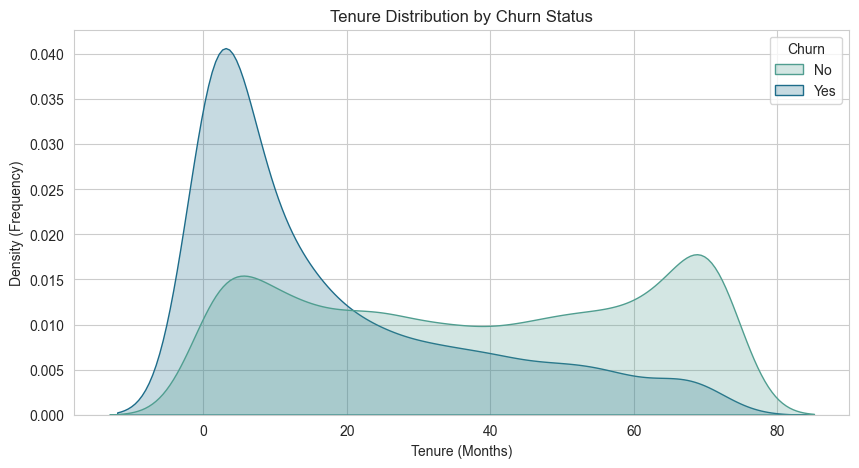

In [41]:
# Tenure vs Churn (Customer Loyalty)
plt.figure(figsize=(10, 5))
sns.kdeplot(data=df, x='tenure', hue='Churn', fill=True, palette='crest', common_norm=False)
plt.title('Tenure Distribution by Churn Status')
plt.xlabel('Tenure (Months)')
plt.ylabel('Density (Frequency)')
plt.show()
# If the "Yes" curve spikes near 0-10 months, new customers are at highest risk.

### DATA CLEANING

In [42]:
# Fix 'TotalCharges' Data Type
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [43]:
# Check how many missing values were created
missing_tc = df['TotalCharges'].isnull().sum()
print(f"Missing values found in TotalCharges after conversion: {missing_tc}")


Missing values found in TotalCharges after conversion: 11


In [44]:
# Handle Missing Values
# We fill the missing values with 0 (assuming 0 tenure means 0 charges)
df['TotalCharges'] = df['TotalCharges'].fillna(0)

# Verify cleaning
print(f"Remaining Missing Values: {df.isnull().sum().sum()}")

Remaining Missing Values: 0


### REMOVING UNNECESSARY COLUMNS

In [45]:
# 'customerID' is unique to every row and has no predictive power
if 'customerID' in df.columns:
    df.drop(columns=['customerID'], inplace=True)
    print("Column 'customerID' dropped successfully.")
else:
    print("Column 'customerID' already dropped.")

# Check shape after dropping
print(f"New Shape: {df.shape}")

Column 'customerID' dropped successfully.
New Shape: (7043, 20)


### DATA VISUALIZATION

C:\Users\User\AppData\Local\Temp\ipykernel_47680\2474128622.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=df, palette='viridis')


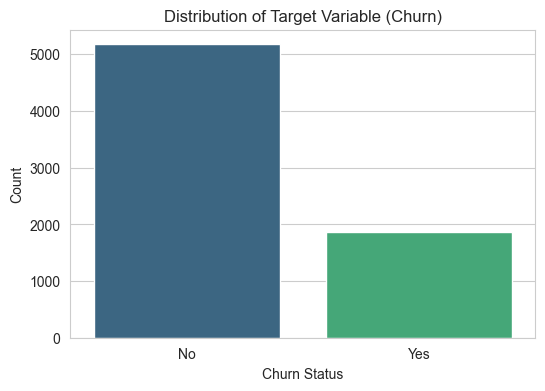

In [46]:
# Target Variable Distribution (Univariate Analysis)
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df, palette='viridis')
plt.title('Distribution of Target Variable (Churn)')
plt.xlabel('Churn Status')
plt.ylabel('Count')
plt.show()

In [47]:
# Calculate percentages
churn_rate = df['Churn'].value_counts(normalize=True) * 100
print(f"Churn Rate:\n{churn_rate}")

Churn Rate:
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


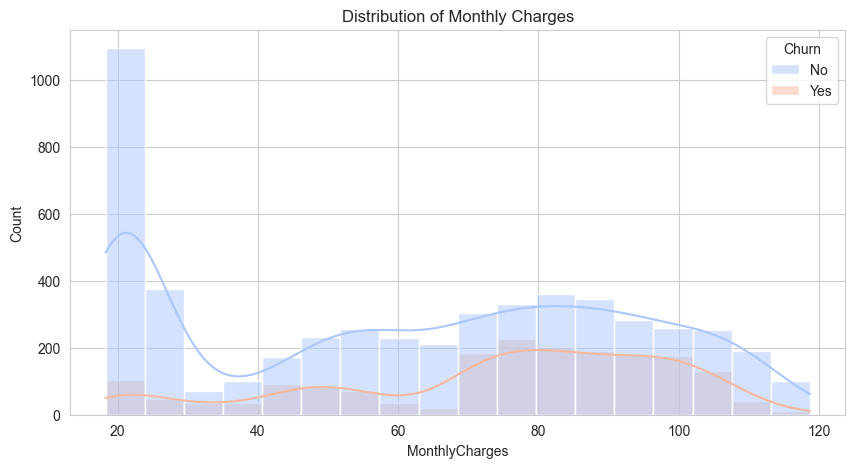

In [48]:
# Numerical Feature Distribution
# Monthly Charges
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='MonthlyCharges', hue='Churn', kde=True, palette='coolwarm')
plt.title('Distribution of Monthly Charges')
plt.show()

### BIVARIATE ANALYSIS

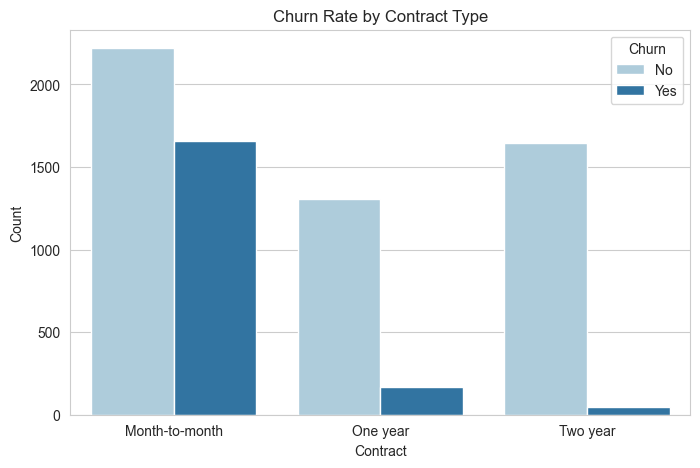

In [49]:
# Churn vs Contract Type
# We analyze if the type of contract (Month-to-month vs One year) affects Churn
plt.figure(figsize=(8, 5))
sns.countplot(x='Contract', hue='Churn', data=df, palette='Paired')
plt.title('Churn Rate by Contract Type')
plt.ylabel('Count')
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_47680\2632854412.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='MonthlyCharges', data=df, palette='coolwarm')


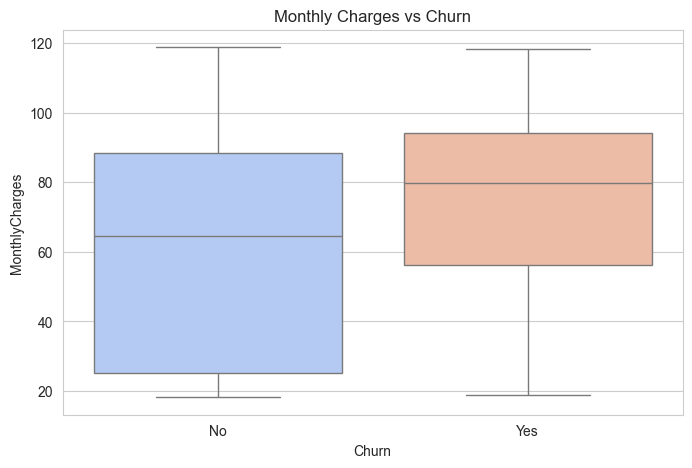

In [50]:
# Churn vs Monthly Charges (Boxplot)
# This helps us see if churned customers generally pay more
plt.figure(figsize=(8, 5))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df, palette='coolwarm')
plt.title('Monthly Charges vs Churn')
plt.show()

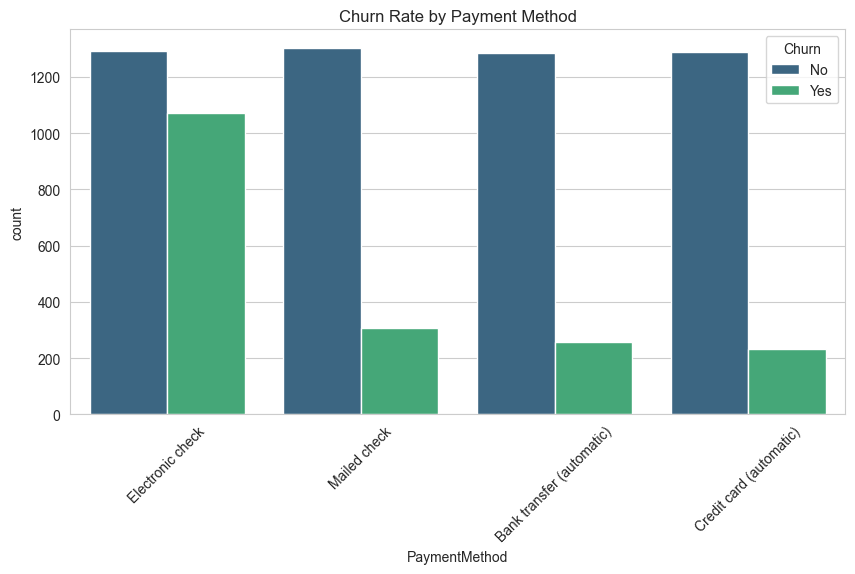

In [51]:
# Churn vs Payment Method
plt.figure(figsize=(10, 5))
sns.countplot(x='PaymentMethod', hue='Churn', data=df, palette='viridis')
plt.title('Churn Rate by Payment Method')
plt.xticks(rotation=45) # Rotate labels to fit
plt.show()

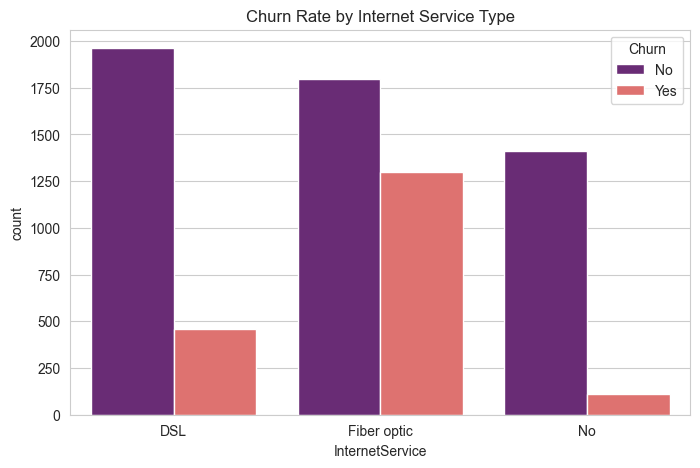

In [52]:
# Does Internet Service Type Impact Churn?
plt.figure(figsize=(8, 5))
sns.countplot(x='InternetService', hue='Churn', data=df, palette='magma')
plt.title('Churn Rate by Internet Service Type')
plt.show()

# Insight: Look at 'Fiber optic'. If the orange bar (Churn=Yes) is disproportionately high,
# it suggests technical issues or pricing dissatisfaction with that specific service.

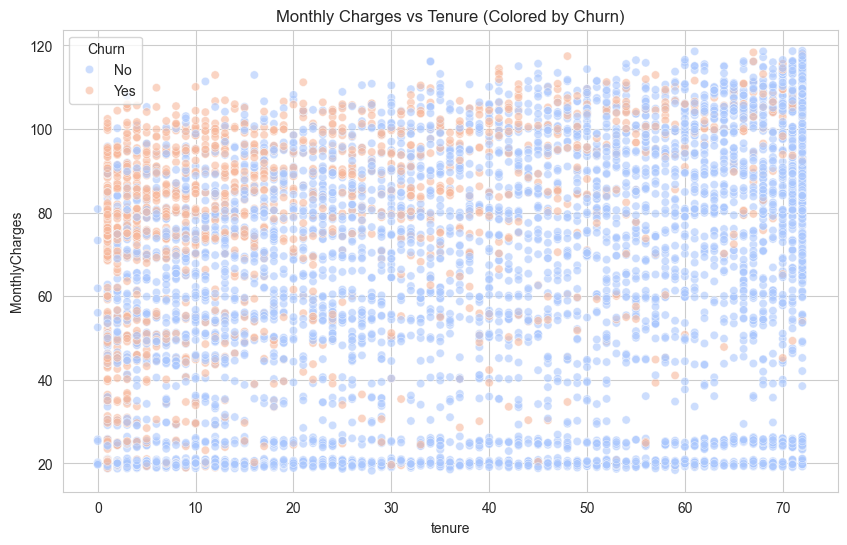

In [53]:
# Interaction between Tenure and Monthly Charges
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='tenure', y='MonthlyCharges', hue='Churn', alpha=0.6, palette='coolwarm')
plt.title('Monthly Charges vs Tenure (Colored by Churn)')
plt.show()

# Insight: Look for the "High Monthly Charge / Low Tenure" quadrant (Top Left).
# If there is a lot of orange there, expensive plans are driving away new users.

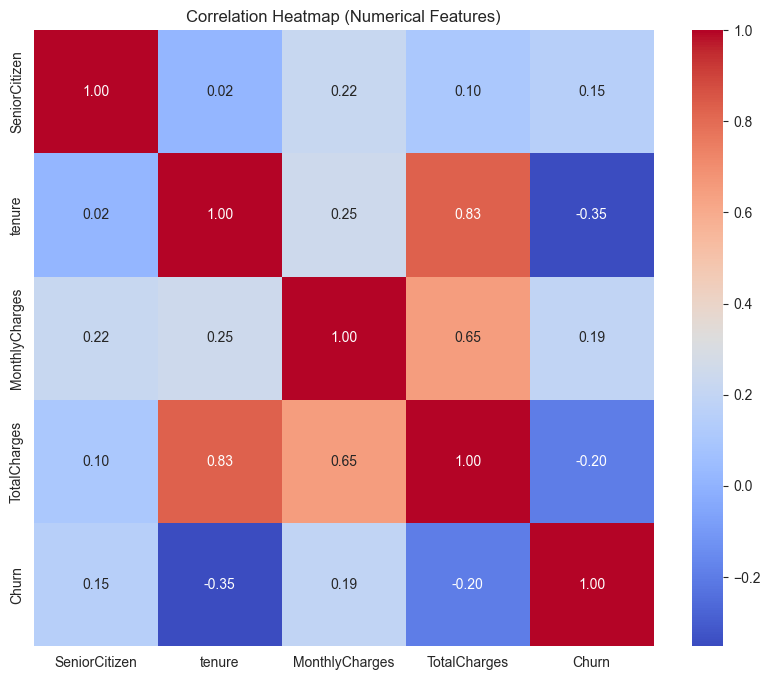

In [54]:
# Correlation Matrix
# We create a temporary copy to convert 'Churn' to numbers for the heatmap
df_corr = df.copy()
df_corr['Churn'] = df_corr['Churn'].map({'Yes': 1, 'No': 0})

# Select only numerical columns for correlation
numeric_df = df_corr.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap (Numerical Features)')
plt.show()

### ENCODING CATEGORICAL VALUES

In [55]:
# Encode Target Variable (Churn)
# Mapping 'Yes' to 1 and 'No' to 0
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# One-Hot Encoding for Categorical Features
# This converts text columns (like Gender, Partner) into numeric binary columns
# drop_first=True is standard practice to reduce redundancy
df_encoded = pd.get_dummies(df, drop_first=True)

# Feature Scaling (Standardization)
# Neural Networks require input features to be on a similar scale (e.g., mean 0, variance 1)
scaler = StandardScaler()
cols_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges']

df_encoded[cols_to_scale] = scaler.fit_transform(df_encoded[cols_to_scale])

In [56]:
# Save the Final Preprocessed Data
# Creating the directory if it doesn't exist
os.makedirs('preprocessed_dataset', exist_ok=True)
output_path = 'preprocessed_dataset/preprocessed_data.csv'

df_encoded.to_csv(output_path, index=False)

print("Encoding and Scaling complete.")
print(f"Final Dataset Shape: {df_encoded.shape}")
print(f"File saved successfully to: {output_path}")

# Display first 5 rows of the ready-for-ML dataset
df_encoded.head()

Encoding and Scaling complete.
Final Dataset Shape: (7043, 31)
File saved successfully to: preprocessed_dataset/preprocessed_data.csv


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,-1.277445,-1.160323,-0.992611,0,False,True,False,False,True,...,False,False,False,False,False,False,True,False,True,False
1,0,0.066327,-0.259629,-0.172165,0,True,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
2,0,-1.236724,-0.362660,-0.958066,1,True,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
3,0,0.514251,-0.746535,-0.193672,0,True,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
4,0,-1.236724,0.197365,-0.938874,1,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False
